In [ ]:
!pip install transformers
!pip install evaluate
!pip install accelerate -U
!pip install torchmetrics
!pip install optuna
!pip install -U "neptune[optuna]"
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel,AutoTokenizer,AdamW
from tqdm import tqdm
import evaluate
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
import random
from torchmetrics.classification import BinaryAccuracy
import optuna
from google.colab import userdata
import neptune
import uuid
import neptune.integrations.optuna as npt_utils
import  hashlib
import time
import math
import shap
import pandas as pd

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NEPTUNE_API_TOKEN"] = userdata.get('NEPTUNE_API_TOKEN')
device = torch.device("cuda:0"  if torch.cuda.is_available() else "cpu")

In [ ]:
# @title Define Transformer Model Name
bert_model_name = "bert-base-cased" # @param {type:"string"}

In [ ]:
# @title Define Hugging Face Dataset Name
dataset_name = "krishan-CSE/HatEval_Relabled_with_Emotion" # @param {type:"string"}

In [ ]:
# @title  Define Neptuna Project Name,Study & Best Trial ID
study_id = "EM-598" # @param {type:"string"}
trial_id = "EM-673" # @param {type:"string"}
project_name="krishanchavinda.official/Emotion-DCL-Framework"

In [ ]:
run_study = neptune.init_run(with_id=study_id,project=project_name,mode='read-only')

https://app.neptune.ai/krishanchavinda.official/Emotion-DCL-Framework/e/EM-598


In [ ]:
run_trial = neptune.init_run(with_id=trial_id,project=project_name,mode='read-only')

https://app.neptune.ai/krishanchavinda.official/Emotion-DCL-Framework/e/EM-673


In [ ]:
best_prams=run_trial["parameters"].fetch()

In [ ]:
#@title #Variables
SEED = 1234 # @param {type:"integer"}
PADDING_MAX_LENGTH = 45 # @param {type:"integer"}

# Setting Random Seed for Reproducibility

In [ ]:
def setup_seed(seed:int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
setup_seed(SEED)

# Loading Test Dataset

In [ ]:
data_files = {"test": "test.csv"}
dataset = load_dataset(dataset_name, data_files=data_files)

# Loading the Tokernizer for the Transformer Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

##Define the Tokenizer Function

In [ ]:
def tokenize_function(examples):
    return tokenizer.batch_encode_plus(examples["text"], padding='max_length',max_length=PADDING_MAX_LENGTH,add_special_tokens=True,truncation=True)

## Tokenize the Dataset

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [ ]:
# Define a function to merge columns into a list
def merge_emotion_columns_to_list(example):
    return {'emotion_vector': [example['anger'], example['anticipation'], example['disgust'],example['fear'],example['joy'],example['love'],example['optimism'],example['pessimism'],example['sadness'],example['surprise'],example['trust']]}

# Apply the function to each example in the dataset
tokenized_datasets = tokenized_datasets.map(merge_emotion_columns_to_list)

## Remove Unwanted Coloumns

In [ ]:
tokenized_datasets=tokenized_datasets.remove_columns(['text','anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])

## Format the coloumns

In [ ]:
tokenized_datasets=tokenized_datasets.with_format("torch")

# Creating DataLoaders for Test Dataset

In [ ]:
test_dataloader=DataLoader(tokenized_datasets["test"], batch_size=best_prams["BATCH_SIZE"] , shuffle=False)

# Define the Dual Contrastive Learning Architecture

In [ ]:
class DCLArchitecture(nn.Module):
    def __init__(self,dropout:float,bert_model_name:str='bert-base-cased'):
        super(DCLArchitecture, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dim = 768
        self.dense = nn.Linear(self.dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,batch_tokenized, if_train=False):
        input_ids = batch_tokenized['input_ids']
        attention_mask = batch_tokenized['attention_mask']
        bert_output = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]

        if if_train:
            bert_cls_hidden_state_aug = self.dropout(bert_cls_hidden_state)
            bert_cls_hidden_state = torch.cat((bert_cls_hidden_state, bert_cls_hidden_state_aug), dim=1).reshape(-1, self.dim)
        else:
            bert_cls_hidden_state = self.dropout(bert_cls_hidden_state)

        linear_output = self.dense(bert_cls_hidden_state)
        linear_output = linear_output.squeeze(1)

        return bert_cls_hidden_state, linear_output

# Define the Extended DCL Architecture with Emotions

In [ ]:
class EmotionGuidedDCLModel(nn.Module):
    def __init__(self,dcl_model:nn.Module,dropout:float=0.25):
        super(EmotionGuidedDCLModel, self).__init__()
        self.dcl_model = dcl_model
        self.dim = 779
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.dim, 1)
        # Freeze all layers
        for param in self.dcl_model.parameters():
            param.requires_grad = False

    def forward(self,batch_tokenized):
        input_ids = batch_tokenized['input_ids']
        attention_mask = batch_tokenized['attention_mask']
        emotion_vector = batch_tokenized['emotion_vector']
        bert_output = self.dcl_model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]
        combined_vector =torch.cat((bert_cls_hidden_state,emotion_vector), 1)
        d_combined_vector=self.dropout(combined_vector)
        linear_output = self.linear(d_combined_vector)
        pred_linear = linear_output.squeeze(1)
        return pred_linear

#Configuring the Model & Focal Loss

In [ ]:
dcl_model = DCLArchitecture(bert_model_name=bert_model_name,dropout=best_prams["DROPOUT"])
dcl_model.to(device)

DCLArchitecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
fined_tuned_bert_model=dcl_model.bert

In [ ]:
model = EmotionGuidedDCLModel(dcl_model=fined_tuned_bert_model,dropout=best_prams["DROPOUT"])
model.to(device)

EmotionGuidedDCLModel(
  (dcl_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Load the Best Trail Checkpoint

In [ ]:
def load_checkpoint(run: neptune.Run,check_point_name:str):
    model_ext = run[check_point_name]["model"].fetch_extension()
    run[check_point_name]["model"].download()  # Download the checkpoint
    run.wait()
    # Load the checkpoint
    checkpoint = {
        "model_state_dict":torch.load(f"model.{model_ext}"),
    }
    return checkpoint

In [ ]:
check_point_name="model_checkpoints/"

In [ ]:
checkpoint=load_checkpoint(run_study,check_point_name)

In [ ]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [ ]:
model.eval()

EmotionGuidedDCLModel(
  (dcl_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
fined_tuned_dcl_model=model.dcl_model

#Get Predictions For Test Dataset

In [ ]:
predictions=torch.tensor([],device=device)

In [ ]:
tot_labels=torch.tensor([],device=device)

In [ ]:
for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        emotion_vector = batch['emotion_vector']
        labels =batch['labels']
        bert_output = fined_tuned_bert_model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]
        combined_vector =torch.cat((bert_cls_hidden_state,emotion_vector), 1)
        tot_labels = torch.cat((tot_labels,labels ), dim=0)
        predictions= torch.cat(( predictions,combined_vector ), dim=0)


#Emotion Explainablity using SHAP

In [ ]:
linear_layer=model.linear

In [ ]:
# Wrap the model predict function for SHAP
explainer = shap.DeepExplainer(linear_layer,data=predictions[:500,:])

In [ ]:
shap_values=explainer.shap_values(X=predictions[500:,:])

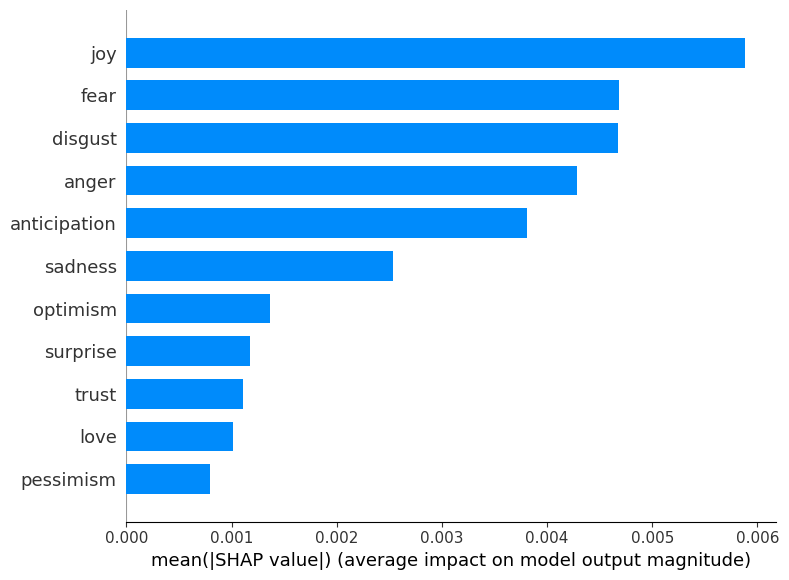

In [ ]:
# Visualize the SHAP values or use them for further analysis
shap.summary_plot(shap_values[:,768:],feature_names=['anger', 'anticipation', 'disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust'],plot_type='bar')

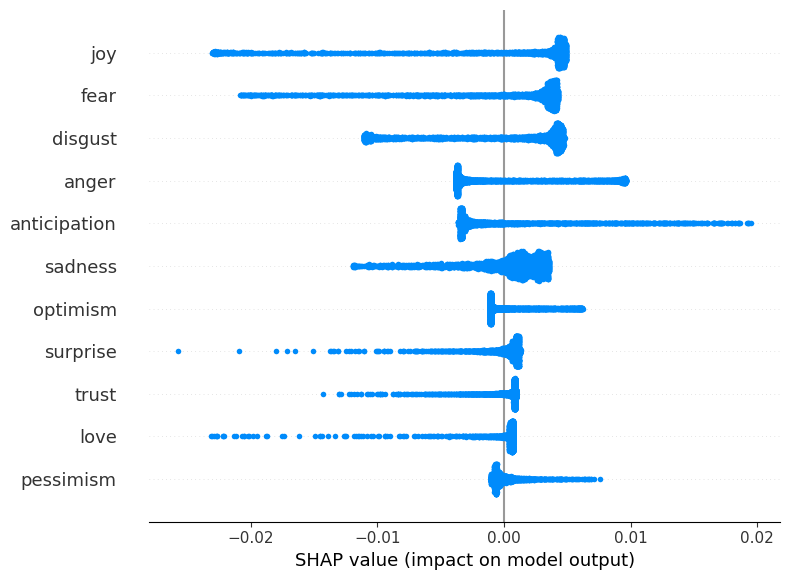

In [ ]:
# Visualize the SHAP values or use them for further analysis
shap.summary_plot(shap_values[:,768:],feature_names=['anger', 'anticipation', 'disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust'])